In [36]:
# Import Required Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import sys
sys.path.append('./src')
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, classification_report


In [37]:
# Colab optional setup
'''
IS_COLAB = "google.colab" in sys.modules
print("Running on Colab:", IS_COLAB)
if IS_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/', force_remount=True)
  #Adapt the folder to your specific one where you have downloaded the code
  %cd /content/drive/My Drive/path_to/exam-project
'''

'\nIS_COLAB = "google.colab" in sys.modules\nprint("Running on Colab:", IS_COLAB)\nif IS_COLAB:\n  from google.colab import drive\n  drive.mount(\'/content/drive/\', force_remount=True)\n  #Adapt the folder to your specific one where you have downloaded the code\n  %cd /content/drive/My Drive/path_to/exam-project\n'

# Model Evaluation on PlantVillage Dataset

This notebook evaluates the trained model using the test set. It includes metrics, confusion matrix, ROC curves, and a classification report.

Be careful if you are running this on COLAB or locally.
Due to some bugs, datasets creation is different.
Change the lower COLAB bool to True if running on COLAB.

In [38]:
COLAB = False  # if True, run on Google Colab, else on local repository

In [39]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32


IF RUNNING ON COLAB

In [40]:
if COLAB: #if running on colab
    ds_info = tfds.builder('plant_village').info
    ds_test = tfds.load('plant_village', split='train[95%:]', as_supervised=True)

    class_names = ds_info.features['label'].names
    families = sorted({n.split('___')[0] for n in class_names})
    split_labels = families
    family_map = tf.constant([families.index(n.split('___')[0]) for n in class_names], dtype=tf.int32)

    # returns label as one-hot
    def to_ohe(img, lbl):
      idx = tf.gather(family_map, lbl)
      return img, tf.one_hot(idx, len(split_labels))

    ds_test  = ds_test.map(to_ohe)
    ds_test = ds_test.map(lambda img, lbl: preprocess(img, lbl, IMG_SIZE)).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

IF RUNNING ON LOCAL REPOSITORY

In [41]:
# Define local path to generate split
if not COLAB:
    from pathlib import Path
    from preprocessing import preprocess

    base_path = Path(r"D:\progetto-daml") #Change according to the path where PlantVillage-Dataset is cloned. Same as training notebook
    base_path = base_path / "PlantVillage-Dataset"

    OUTPUT_ROOT = base_path / "by_family" # 14 families splitting

    # read test set
    split_labels = sorted([p.name for p in (OUTPUT_ROOT/"train").iterdir() if p.is_dir()]) #folders names
    test_ds = tf.keras.utils.image_dataset_from_directory(
        str(OUTPUT_ROOT/"test"),
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        label_mode='categorical',
        shuffle=False,
    )
    

Found 2747 files belonging to 14 classes.


# Model selection and test evaluation

In [50]:
models = {
    0: "best_model_basecnn_14_families.h5", # run with import from directory
    1: "best_model_14_families_categorical_l2coeff_1e-3.h5", # run with import from directory
    2: "best_model_14_families_focal_l2coeff_1e-3.h5", # run with import from directory
    3: "best_model_14_families_transfer_mobilenet.h5" # run wit import through tfds.load
}

# model selection through index
n = 3

model_name = models.get(n)
if model_name is None:
    print(f"No file associated to {n}")
else:
    model_path = f"./weights/{model_name}"
    print(f"Model file name: {model_name}")

Model file name: best_model_14_families_transfer_mobilenet.h5


In [51]:
import tensorflow_datasets as tfds

# Load Trained Model and Test Data
model = keras.models.load_model(model_path) 


In [52]:
# Generate Predictions on Test Set
y_true = []
y_pred = []
y_score = []
for images, labels in test_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_score.append(preds)
y_score = np.concatenate(y_score)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [53]:
# Calculate Evaluation Metrics (Accuracy, Precision, Recall, F1)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-score: {f1:.6f}")


Accuracy: 0.073171
Precision: 0.082243
Recall: 0.073171
F1-score: 0.017024


c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


<Figure size 640x480 with 0 Axes>

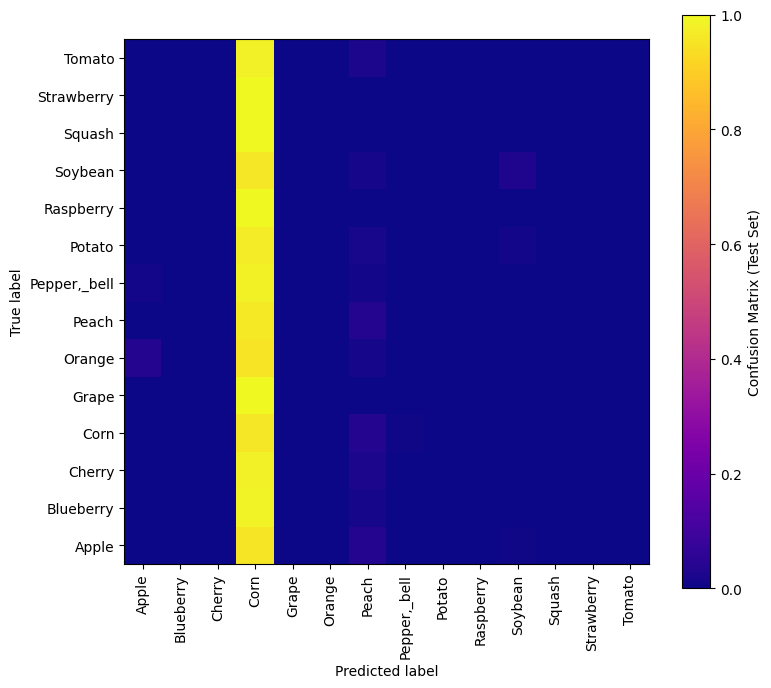

In [47]:
import matplotlib.pyplot as plt
from plotting import plot_confusion_matrix

plt.figure()  # Set a larger figure size for better readability
plot_confusion_matrix(
    np.array(y_true),
    np.array(y_pred),
    classes=split_labels,
    normalize=True,
    title="Confusion Matrix (Test Set)",
    cmap="plasma"
)
plt.tight_layout()  # Ensure labels and ticks are not cut off
plt.savefig(f'./conf-matrix/confusion_matrix_v{model_name}.png', dpi=400, bbox_inches='tight')
plt.show()


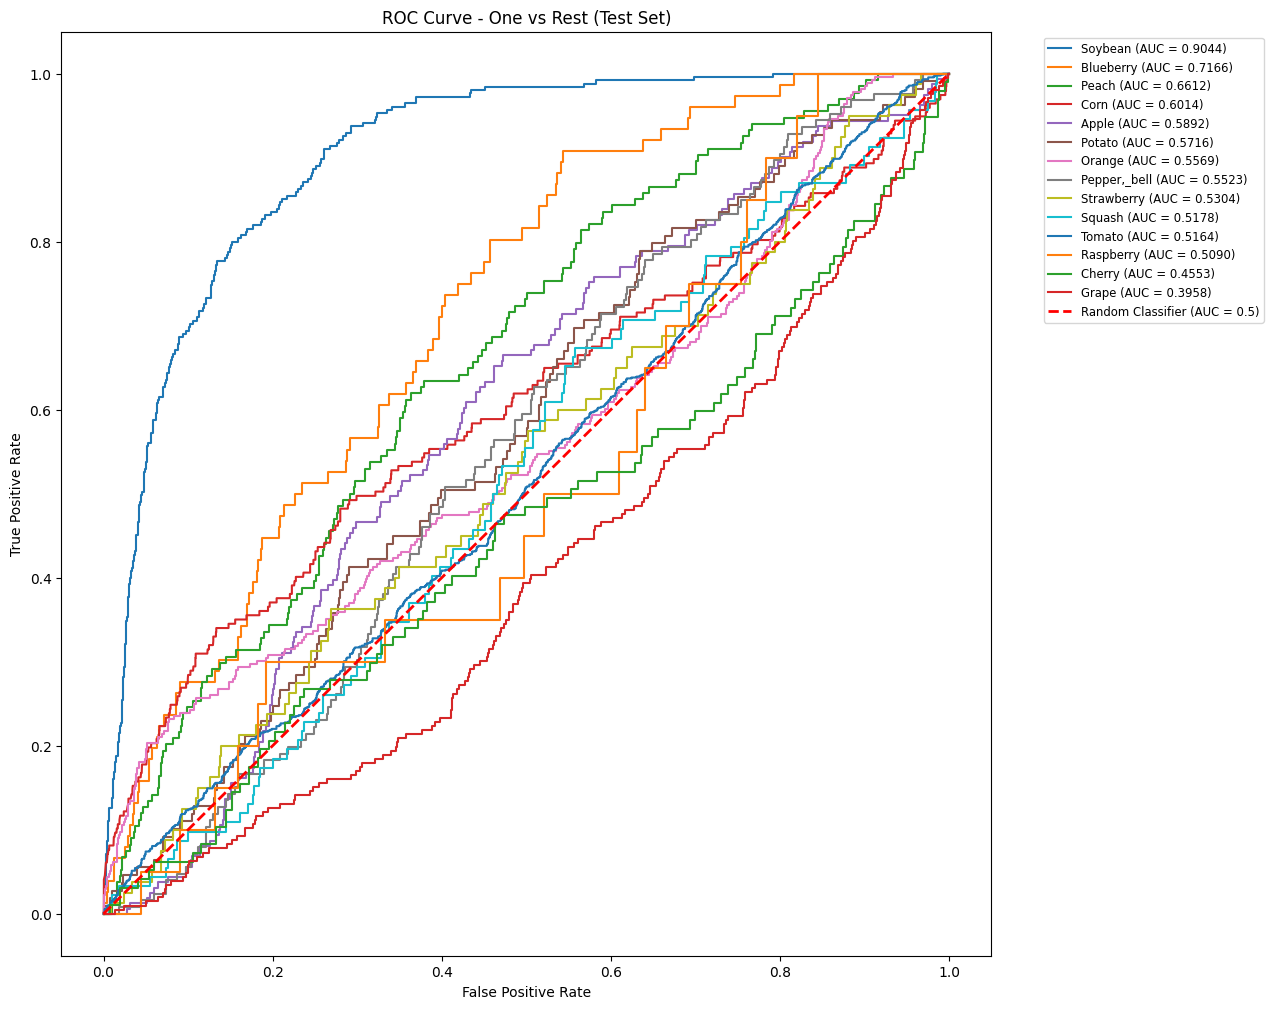

In [48]:
# Plot ROC Curves for Each Class
n_classes = y_score.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.eye(n_classes)[y_true][:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(np.eye(n_classes)[y_true][:, i], y_score[:, i])
plt.figure(figsize=(12, 12))
auc_and_idx = sorted([(roc_auc[i], i) for i in range(n_classes)], reverse=True)
for auc, i in auc_and_idx:
    plt.plot(fpr[i], tpr[i], label=f'{split_labels[i]} (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - One vs Rest (Test Set)')
plt.legend(fontsize='small', bbox_to_anchor=(1.05, 1), loc='best')
plt.savefig(f'./roc-curves/roc_curve_v{model_name}.png', dpi=400, bbox_inches='tight')
plt.show()


In [49]:
# Display Classification Report
report = classification_report(y_true, y_pred, target_names=split_labels)
print(report)

# Save the classification report to a text file
with open(f'./reports/report_v{model_name}.txt', 'w') as f:
    f.write(report)


              precision    recall  f1-score   support

       Apple       0.00      0.00      0.00       161
   Blueberry       0.00      0.00      0.00        76
      Cherry       0.00      0.00      0.00        97
        Corn       0.07      0.96      0.13       197
       Grape       0.00      0.00      0.00       206
      Orange       0.00      0.00      0.00       276
       Peach       0.10      0.04      0.05       134
Pepper,_bell       0.00      0.00      0.00       126
      Potato       0.00      0.00      0.00       109
   Raspberry       0.00      0.00      0.00        20
     Soybean       0.78      0.03      0.05       255
      Squash       0.00      0.00      0.00        92
  Strawberry       0.00      0.00      0.00        80
      Tomato       0.00      0.00      0.00       918

    accuracy                           0.07      2747
   macro avg       0.07      0.07      0.02      2747
weighted avg       0.08      0.07      0.02      2747



c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Utente\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(